# Getting Started

Follow the general instructions from hw1_Q1

In [2]:
# get to the parent dir of mai_dul repo
import os

# os.chdir('../../')
os.getcwd()

'/home/ordem/PycharmProjects/MAI_DUL_WS24/homeworks/hw1'

In [ ]:
# run only once at the beginning of working on hw1
# !unzip -qq homeworks/hw1/data/hw1_data.zip -d homeworks/hw1/data/

# install latest version deepul package
# !pip install -e .

In [3]:
import numpy as np
from deepul.hw1_helper import (
    # Q5
    visualize_q5_data,
    q5a_save_results,
)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [4]:
data = visualize_q5_data()

Sample 1
Michael Anania, Tracings from Selected Poems. Copyright  1994 by Michael Anania. Used by permission of Asphodel Press/Acorn Alliance.
--------------------------------------------------------------------------------

Sample 2
When to the sessions of sweet silent thought
I summon up remembrance of things past,
I sigh the lack of many a thing I sought,
And with old woes new wail my dear time's waste:
Then can I drown an eye, unus'd to flow,
For precious friends hid in death's dateless night,
And weep afresh love's long since cancell'd woe,
And moan th' expense of many a vanish'd sight;
Then can I grieve at grievances foregone,
And heavily from woe to woe tell o'er
The sad account of fore-bemoaned moan,
Which I new pay as if not paid before.
But if the while I think on thee, dear friend,
All losses are restor'd, and sorrows end.
--------------------------------------------------------------------------------

Sample 3
Adieu, farewell, earths bliss;
This world uncertain is;
Fond ar

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [6]:

from models.GATModel import GATModel
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import math
import torch


def create_non_overlapping_windows(tokens, context_size, padding):
    tokens_tensor = torch.tensor(tokens)
    padded_length = context_size * math.ceil(len(tokens) / context_size)
    return torch.cat((tokens_tensor, torch.full((padded_length - len(tokens),), padding)), dim=0).unflatten(0, (
    context_size, padded_length // context_size))


def q5_a(train_text, test_text):
    """
    train_text: list[str] Train text sequences.
    test_text: list[str] Test text sequences.
    
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 5 (str), 5 generated samples from the model.
    """
    batch_size = 128
    learning_rate = 0.00001
    max_epochs = 50
    context_length = 128
    vocabulary = ["<bos>", *list(set("".join(train_text + test_text))), "<eos>"]
    vocab_to_index = {value: index + 1 for index, value in enumerate(vocabulary)}

    x_train = [item for text in train_text for item in [0, *[vocab_to_index[c] for c in text], len(vocabulary) - 1]]
    x_test = [item for text in train_text for item in [0, *[vocab_to_index[c] for c in text], len(vocabulary) - 1]]
    x_train = create_non_overlapping_windows(x_train, context_length, len(vocabulary) - 1).T
    x_test = create_non_overlapping_windows(x_test, context_length, len(vocabulary) - 1).T

    train_dataset = TensorDataset(x_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x_test = x_test.to(device)

    model = GATModel(vocab_size=len(vocabulary))
    model.to(device)

    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    for epoch in range(max_epochs):
        batches = iter(train_loader)

        batch_train_loss = np.empty(len(batches))
        for i, [batch_x] in enumerate(batches):
            batch_x = batch_x.to(device)
            logits = model.forward(batch_x)

            loss = model.loss_function(logits, batch_x)
            batch_train_loss[i] = loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_losses.append(batch_train_loss.mean().item())

        model.eval()
        with torch.no_grad():
            test_logits = model.forward(x_test)
            test_loss = model.loss_function(test_logits, x_test)
            test_losses.append(test_loss.item())
        model.train()
        print(f"epoch {epoch + 1}/{max_epochs}, train loss: {train_losses[-1]}, test loss: {test_losses[-1]}")
    samples = model.generate(5, max_sequence_length=128, device=device).numpy(force=True)
    text_samples = ["".join([vocabulary[vi] for vi in sample]) for sample in samples]
    return train_losses, test_losses, text_samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



Generating new samples
Final Test Loss: 1.6281


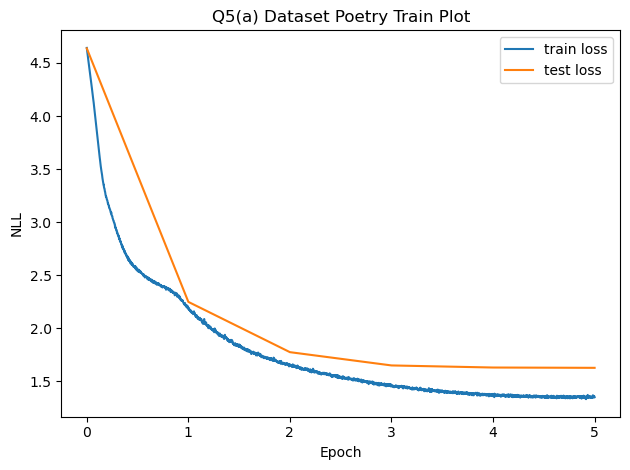

Sample 1
ghe his soon more memow;
My made a callen with youth eyes coming,
"Plate that I bride nought elseteness we make
To enseave an

Sample 2
eight    
An! 
Than dread the sweete prevail
Arry away thered now shall past is mist
Or all this king out of not queen
And 

Sample 3
954 by Crad frend Sweet Ezropic XUS bridall silvery aslay to kept,
Wafting be oft, the Januarhaphoes, That I
Till hath full of

Sample 4
wit his lust
   And summit so be a such more;
   For for soft being and stealdising smile,
From the golden of yourself there?

Sample 5
5HgQuemon one;   
That thou thyne eyes whateful. Crimmering is: )
By dear a dialing spong, or hate?
The wild Groldiar nor car



In [8]:
q5a_save_results(q5_a)